In [1]:
import os

import numpy as np
import pandas as pd
from IPython.display import display

# Check if the environment is activated
if "CONDA_DEFAULT_ENV" in os.environ:
    print(f"Environment '{os.environ['CONDA_DEFAULT_ENV']}' is activated.")
else:
    print("No specific environment is activated.")

RANDOM_SEED = 42 # For final model reproducibility
np.random.seed(RANDOM_SEED)

cv = None
scorer = None
X_test = None
y_test = None

Environment 'research' is activated.


In [2]:
# # Load the Boston dataset
# dataset = "boston"
# raw_df = pd.read_csv("data/boston.csv")
# target = ["MEDV"]
# features = raw_df.columns.drop(target)
# target, features

In [3]:
# # Load the store sales dataset
# dataset = "store_sales"
# excel_file = pd.ExcelFile("data/store_sales.xlsx")
# sheet_names = excel_file.sheet_names

# # Read the data
# raw_df = pd.read_excel(excel_file, sheet_name=sheet_names[2])  # 2, 9
# iri_key_counts = raw_df["IRI_KEY"].value_counts()
# iri_keys = iri_key_counts[iri_key_counts > 300].index


# target = ["Total.Volume"]
# features = ["F", "D", "Unit.Price"]

# raw_df = raw_df[raw_df["IRI_KEY"] == iri_keys[0]]

# sheet_names, iri_keys

In [4]:
# # Load the California housing dataset
# from sklearn.datasets import fetch_california_housing

# dataset = "california"
# housing = fetch_california_housing()
# target = housing.target_names
# features = housing.feature_names
# raw_df = pd.concat(
#     [
#         pd.DataFrame(housing.data, columns=housing.feature_names),
#         pd.DataFrame(housing.target, columns=housing.target_names),
#     ],
#     axis=1,
# )
# target, features

In [5]:
# # Load the soybean dataset
# dataset = "soybean"
# raw_df = pd.read_excel("data/soybean.xlsx")
# # X = raw_df.values[:-1, [5, 6, 15, 16, 17, 26,
# #                         34, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]]  # 9 check yield 12 rm band
# # y = raw_df.values[:-1, 11]
# X = raw_df.iloc[:-1, [5, 6, 15, 16, 17, 26,
#                   34, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]]
# y = raw_df.iloc[:-1, [11]]
# X.shape, y.shape

In [6]:
# # Load LengthOfStay
# dataset = "LengthOfStay"
# raw_df = pd.read_csv("data/LengthOfStay.csv")
# raw_df = raw_df.drop(columns=["eid", "vdate", "discharged"])
# target = ["lengthofstay"]
# features = raw_df.columns.drop(target)
# target, features

In [7]:
# # Load HospitalStay
# dataset = "HospitalStay"
# raw_df = pd.read_csv("data/Healthcare_Investments_and_Hospital_Stay.csv")
# target = ["Hospital_Stay"]
# features = raw_df.columns.drop(target)
# target, features

In [8]:
# Load AssetPricing
from sklearn import preprocessing
from sklearn.metrics import make_scorer
from sklearn.model_selection import TimeSeriesSplit

dataset = "AssetPricing"

################################################################################
# Characteristics
# Variables are constructed using Green, Hand, and Zhang (2017)'s sas code
# absacc  : Absolute accruals
# beta    : Beta
# cfp     : Cash flow to price ratio
# chpmia  : Industry-adjusted change in profit margin
# ep      : Earnings to price
# gma     : Gross profitability
# herf    : Industry sales concentration
# idiovol : Idiosyncratic return volatility
# lev     : Leverage
# mom12m  : 12-month momentum
# mom6m   : 6-month momentum
# nincr   : Number of earnings increases
# pchdepr : % change in depreciation
# ps      : Financial statements score
# roavol  : Earnings volatility
# roeq    : Return on equity
# salecash: Sales to cash
# stdcf   : Cash flow volatility
# sue     : Unexpected quarterly earnings
# tang    : Debt capacity/firm tangibility
features = [
    "absacc",
    "beta",
    "cfp",
    "chpmia",
    "ep",
    "gma",
    "herf",
    "idiovol",
    "lev",
    "mom12m",
    "mom6m",
    "nincr",
    "pchdepr",
    "ps",
    "roavol",
    "roeq",
    "salecash",
    "stdcf",
    "sue",
    "tang",
]
target = ["exret"]


def winsorize(X, q):
    """Winsorizes a pandas Series or numpy array."""
    X = X.copy()
    q_l = np.nanquantile(X, q)
    q_u = np.nanquantile(X, 1 - q)
    if pd.isna(q_l):
        q_l = -np.inf
    if pd.isna(q_u):
        q_u = np.inf
    X[X < q_l] = q_l
    X[X > q_u] = q_u
    return X


def cal_r2(y_true, y_pred):
    """Calculates R2 according to Gu, Kelly, and Xiu (2020)."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    sse = np.sum(np.square(y_true - y_pred))
    sst = np.sum(np.square(y_true))  # Denominator without demeaning
    if sst == 0:
        return 100.0 if sse == 0 else -np.inf
    r2 = 100 * (1 - sse / sst)
    return r2


# Sample split
# Training/Validation sample  : 2000 ~ 2019 (15 years)
# ym = (year - 1960) * 12 + (month - 1)
train_val_start_year = 2000
train_val_end_year = 2014
test_start_year = 2015
test_end_year = 2019

# Calculate ym ranges
ym_train_val_st = (train_val_start_year - 1960) * 12
ym_train_val_ed = (train_val_end_year - 1960) * 12 + 11
ym_test_st = (test_start_year - 1960) * 12
ym_test_ed = (test_end_year - 1960) * 12 + 11

################################################################################
# Load data
# Remove microcap stocks whose market capitalization fall below the 20th NYSE cutpoint
# lme   : 1-month-lagged market equity
# retadj: stock monthly return (adjust for delisting)
# exret : excess return (= retadj - rf)
# rf    : risk-free rate
raw_df = pd.read_stata("data/ML_sample.dta")
raw_df["ym"] = (raw_df["year"] - 1960) * 12 + (raw_df["month"] - 1)
raw_df = raw_df.astype({"permno": "int", "year": "int", "month": "int", "ym": "int"})
raw_df = raw_df[["permno", "year", "month", "ym", "lme", "retadj", "exret"] + features]
raw_df = raw_df.sort_values(by=["ym", "permno"], ascending=True).reset_index(drop=True)
assert not raw_df.duplicated(subset=["ym", "permno"]).any()

# Data Preparation
print("Preparing data (winsorizing, standardizing)...")
train_val_mask = (raw_df["ym"] >= ym_train_val_st) & (raw_df["ym"] <= ym_train_val_ed)
test_mask = (raw_df["ym"] >= ym_test_st) & (raw_df["ym"] <= ym_test_ed)

# Winsorize target only in train/val period
raw_df["exret_winsor"] = raw_df["exret"]
raw_df.loc[train_val_mask, "exret_winsor"] = (
    raw_df.loc[train_val_mask].groupby("ym")["exret"].transform(winsorize, q=0.01)
)

# Cross-sectional standardization (monthly)
CMat = raw_df[features].values.copy()
unique_yms = raw_df["ym"].unique()
for ym_i in unique_yms:
    idx_i = raw_df.index[raw_df["ym"] == ym_i].tolist()
    if len(idx_i) > 1:
        month_data = CMat[idx_i, :]
        scaler = preprocessing.StandardScaler()
        scaled_data = scaler.fit_transform(month_data)
        np.nan_to_num(scaled_data, copy=False, nan=0.0)
        CMat[idx_i, :] = scaled_data
    elif len(idx_i) == 1:
        CMat[idx_i, :] = 0  # Set features to 0 if only one stock
CMat[np.isnan(CMat)] = 0  # Fill original NaNs
raw_df[features] = CMat
del CMat


raw_df.loc[train_val_mask, "exret"] = raw_df.loc[train_val_mask, "exret_winsor"]
X_test = raw_df.loc[test_mask, features]
y_test = raw_df.loc[test_mask, target]
raw_df=raw_df.loc[train_val_mask]

cv = TimeSeriesSplit(n_splits=5)
scorer = make_scorer(cal_r2, greater_is_better=True)

target, features

Preparing data (winsorizing, standardizing)...


(['exret'],
 ['absacc',
  'beta',
  'cfp',
  'chpmia',
  'ep',
  'gma',
  'herf',
  'idiovol',
  'lev',
  'mom12m',
  'mom6m',
  'nincr',
  'pchdepr',
  'ps',
  'roavol',
  'roeq',
  'salecash',
  'stdcf',
  'sue',
  'tang'])

In [9]:
import time

output_folder = f"output/{dataset}_{time.strftime('%F_%T')}"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
if not os.path.exists(f"{output_folder}/models"):
    os.makedirs(f"{output_folder}/models")

X = raw_df[features]
y = raw_df[target]

display(f"output: {output_folder}", X.describe(), y.describe(), X, y)

'output: output/AssetPricing_2025-04-03_14:27:51'

,absacc,beta,cfp,chpmia,ep,gma,herf,idiovol,lev,mom12m,mom6m,nincr,pchdepr,ps,roavol,roeq,salecash,stdcf,sue,tang
count,3.236010e+05,3.236010e+05,3.236010e+05,3.236010e+05,3.236010e+05,3.236010e+05,3.236010e+05,3.236010e+05,3.236010e+05,3.236010e+05,3.236010e+05,3.236010e+05,3.236010e+05,3.236010e+05,3.236010e+05,3.236010e+05,3.236010e+05,3.236010e+05,3.236010e+05,3.236010e+05
mean,1.010039e-17,-8.111053e-17,-2.744671e-19,1.289996e-17,-4.446368e-17,-7.054684e-16,1.787681e-15,3.504396e-17,1.349610e-16,6.573488e-17,-6.054745e-17,2.854458e-18,-7.513264e-17,2.549251e-17,-8.122032e-17,-4.154335e-17,1.384742e-16,-9.792988e-18,-1.885589e-18,-5.469911e-16
std,9.655292e-01,9.971002e-01,9.814834e-01,9.819304e-01,1.000002e+00,9.841215e-01,1.000002e+00,9.971002e-01,9.985960e-01,9.823347e-01,9.928219e-01,9.991931e-01,9.692252e-01,9.841403e-01,9.707926e-01,9.989488e-01,9.983995e-01,8.849151e-01,9.988018e-01,9.847053e-01
min,-1.151892e+00,-3.009622e+00,-1.250080e+01,-8.670075e+00,-1.845331e+01,-4.003486e+00,-9.411253e-01,-1.511685e+00,-6.356644e-01,-3.232365e+00,-3.857084e+00,-1.008098e+00,-2.988971e+00,-3.880139e+00,-6.641776e-01,-9.853059e+00,-3.812317e-01,-1.828039e-01,-2.374691e+01,-2.346760e+00
25%,-5.804840e-01,-7.171164e-01,-3.946691e-01,-2.154246e-01,-6.708547e-02,-7.118850e-01,-5.770289e-01,-7.061534e-01,-4.704445e-01,-5.582450e-01,-5.705321e-01,-7.316072e-01,-3.637796e-01,-6.371148e-01,-4.258048e-01,-1.239829e-01,-3.178726e-01,-1.176710e-01,-3.784059e-02,-6.091626e-01
50%,-1.913774e-01,-2.023210e-01,-9.053938e-02,-7.295763e-02,1.629539e-01,-1.239614e-01,-3.969639e-01,-2.173816e-01,-3.358688e-01,-1.335287e-01,-9.625879e-02,-1.688415e-01,-9.988488e-02,0.000000e+00,-2.715484e-01,5.205637e-02,-2.714765e-01,-1.045201e-01,1.340725e-02,0.000000e+00
75%,2.203224e-01,5.475363e-01,2.835109e-01,1.522677e-01,3.130758e-01,4.772382e-01,2.022379e-01,4.553005e-01,-3.153289e-02,3.566521e-01,4.431335e-01,3.984001e-01,1.510087e-01,6.702120e-01,0.000000e+00,2.387162e-01,-9.957737e-02,-7.468980e-02,7.413526e-02,5.517151e-01
max,1.029008e+01,3.979946e+00,9.963212e+00,7.592708e+00,4.196642e+00,4.203899e+00,5.070607e+00,8.135730e+00,1.590036e+01,7.574217e+00,7.819509e+00,7.975046e+00,1.113036e+01,2.737248e+00,2.106568e+01,7.125490e+00,1.096817e+01,1.502524e+01,2.749324e+01,3.224758e+00


,exret
count,323601.000000
mean,0.006706
std,0.128837
min,-0.643625
25%,-0.053937
50%,0.007431
75%,0.066903
max,1.506153


,absacc,beta,cfp,chpmia,ep,gma,herf,idiovol,lev,mom12m,mom6m,nincr,pchdepr,ps,roavol,roeq,salecash,stdcf,sue,tang
0,-0.690156,-0.857040,-0.411355,0.801907,0.170149,-0.579857,0.018443,-0.810387,-0.282651,-0.103470,-0.051010,0.442196,-0.582069,-0.329951,-0.097508,0.311925,-0.289520,-0.132251,0.054976,-0.918043
1,0.126002,-0.357085,2.305316,0.002058,0.086384,-0.226436,0.592866,-0.126193,1.037075,-0.001439,-0.238686,1.074700,-0.070389,0.278015,-0.302149,0.187236,0.535416,-0.149556,0.103485,-0.230132
2,-0.051899,1.080846,0.260848,0.112898,0.431458,0.183012,-0.274945,0.134454,-0.541192,-0.183525,0.408566,-0.822813,0.399618,0.885981,-0.327750,0.133899,-0.228731,-0.153705,0.030973,0.849528
3,-0.640968,-0.291570,-0.167427,-0.109576,0.179731,0.551468,0.764738,0.111548,-0.585543,-0.847059,-0.731643,-0.190309,0.119456,1.493947,-0.411624,0.094135,-0.217667,-0.153614,0.036785,-1.293971
4,1.394015,0.195299,-0.146262,0.452210,0.079191,2.091332,-0.331334,-0.137259,-0.603943,1.625209,1.604372,1.074700,0.097725,-0.329951,-0.337636,0.505260,-0.290010,-0.153558,0.026617,0.744188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323596,0.836126,0.520538,1.463529,0.413306,-0.029722,-0.522313,-0.535465,0.042170,-0.098952,-1.176695,-1.497449,-0.863429,0.145686,1.240920,-0.265625,-0.520027,2.459045,-0.110829,0.109113,0.364906
323597,0.446705,-0.452993,0.255441,-0.090215,0.034287,-0.439249,0.341160,-0.343828,-0.323919,0.048266,-0.281679,0.046318,-0.512739,-0.147882,0.772652,2.037718,-0.251402,-0.101515,0.020200,-0.729711
323598,0.868368,1.245353,-0.439144,-0.367815,-0.580032,0.460086,-0.516218,1.698555,-0.447097,-0.896077,0.005400,0.046318,-0.341954,-1.536684,0.674757,-0.154842,-0.313073,-0.111016,0.099140,0.492485
323599,1.042706,-1.252587,-0.347590,-0.071619,0.105541,2.225623,-0.097975,-0.620206,-0.544780,0.150088,0.581552,-0.863429,0.577013,-0.842283,0.203508,1.170714,-0.296222,-0.111051,-0.024853,1.430812


,exret
0,-0.103438
1,0.233764
2,0.052718
3,-0.432444
4,0.010428
...,...
323596,-0.010763
323597,0.061501
323598,0.076010
323599,0.058588


In [10]:
# # Remove Outliers
# def remove_outliers(df, threshold=3):
#     z_scores = np.abs((df - df.mean()) / df.std())
#     return df[(z_scores < threshold).all(axis=1)]
# filtered_train_data = train_data
# for col in train_data.columns:
#     value_counts = train_data[col].value_counts().sort(by="count")
#     valid = value_counts.filter(pl.col("count") > value_counts["count"].max()/len(value_counts))[col]
#     filtered_train_data = filtered_train_data.filter(pl.col(col).is_in(valid))
# display(filtered_train_data, filtered_train_data.describe())

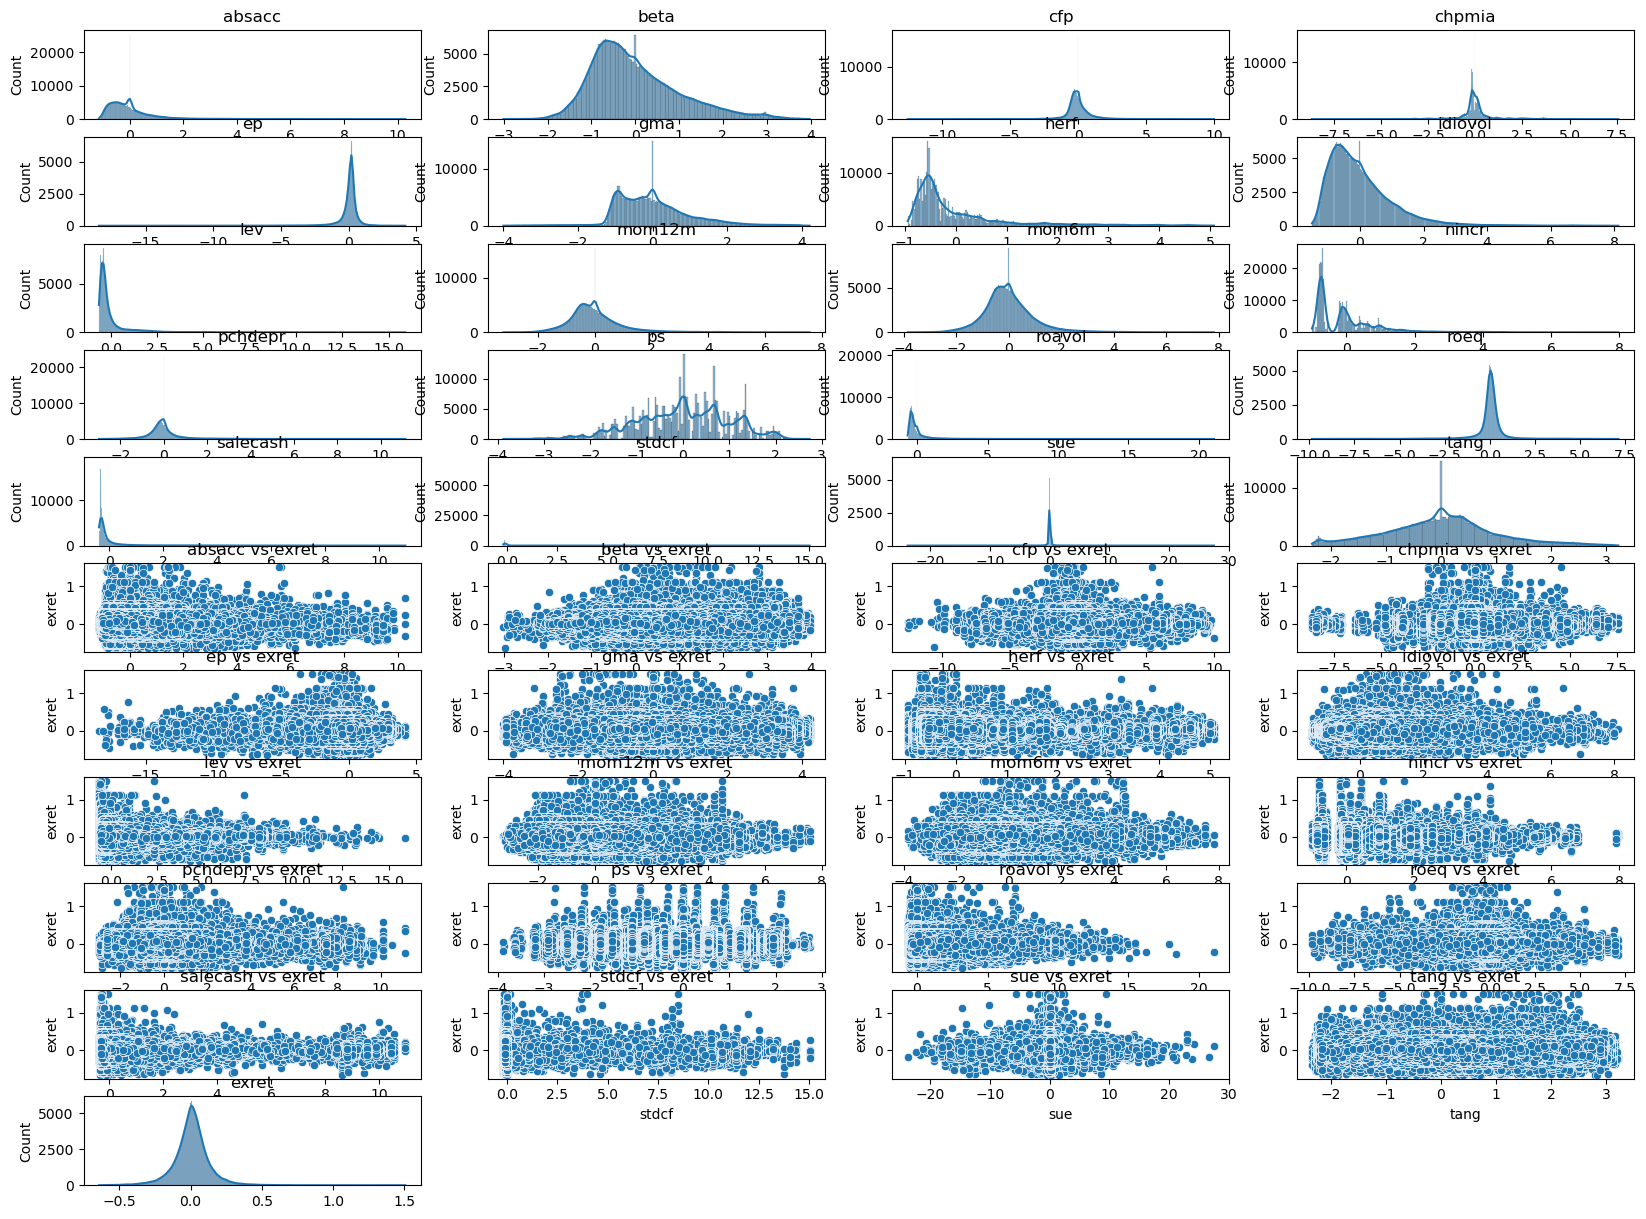

In [11]:
# Plot data
import matplotlib.pyplot as plt
import seaborn as sns


def plot_data(X, y, cols=4):
    fig, axs = plt.subplots(
        (X.shape[1] + X.shape[1] * y.shape[1] + y.shape[1] + cols - 1) // cols,
        cols,
        figsize=(20, 15),
    )
    axs = axs.flatten()

    a = 0
    for i, col in enumerate(X.columns):
        data = X[col].to_numpy()
        ax = axs[a + i]
        sns.histplot(data, kde=True, ax=ax)
        ax.set_title(col)
        ax.set_xlabel(col)
        ax.tick_params(axis="both", which="major")
        ax.tick_params(axis="both", which="minor")
    a += i + 1
    for i, col in enumerate(X.columns):
        data = X[col].to_numpy()
        for j, ycol in enumerate(y.columns):
            ax = axs[a + i + j * y.shape[1]]
            sns.scatterplot(x=data, y=y[ycol], ax=ax)
            ax.set_title(f"{col} vs {ycol}")
            ax.set_xlabel(col)
            ax.set_ylabel(ycol)
    a += i + 1
    for i, col in enumerate(y.columns):
        data = y[col].to_numpy()
        ax = axs[a + i]
        sns.histplot(data, kde=True, ax=ax)
        ax.set_title(col)
    a += i + 1
    for j in range(a, len(axs)):
        fig.delaxes(axs[j])

    # fig.tight_layout()
    return fig


fig = plot_data(X, y)
fig.savefig(f"{output_folder}/data.png")
fig.show()

In [12]:
# Define search
from optuna.integration.sklearn import OptunaSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    QuantileTransformer,
    RobustScaler,
    StandardScaler,
    TargetEncoder,
)

CATEGORICAL_PREPROCESSORS = {
    "drop": "drop",
    "ordinal": OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
    "one_hot": OneHotEncoder(
        handle_unknown="ignore", max_categories=20, sparse_output=False
    ),
    "target": TargetEncoder(target_type="continuous"),
}

SCALERS = {
    "identity": None,
    "standard": StandardScaler(),
    "minmax": MinMaxScaler(),
    "robust": RobustScaler(),
    "quantile": QuantileTransformer(),
}

search_params = {
    "cv": cv or 5,
    "n_jobs": -1,  # -1,
    "n_trials": 10,  # 1
    # "n_trials": None,
    "random_state": 42,
    "return_train_score": True,
    # "scoring": "neg_mean_squared_error",
    "scoring": scorer or "r2",
    # "timeout": 10,
    # "timeout": None,
    "verbose": 0,
}


def search(
    model,
    param_grid={},
    categorical_preprocessor="drop",
    scaler="identity",
    search_params=search_params,
):
    search_params = search_params.copy()
    # search_params["n_trials"] = int(4**len(param_grid))

    numerical_features = X.select_dtypes(include=["number"]).columns
    categorical_features = X.select_dtypes(include=["object", "category"]).columns
    preprocessor = ColumnTransformer(
        [
            ("numerical", "passthrough", numerical_features),
            (
                "categorical",
                CATEGORICAL_PREPROCESSORS[categorical_preprocessor],
                categorical_features,
            ),
        ]
    )

    return OptunaSearchCV(
        Pipeline(
            [
                ("categorical_preprocessor", preprocessor),
                ("scaler", SCALERS[scaler]),
                ("model", model),
            ]
        ),
        {f"model__{k}": v for k, v in param_grid.items()},
        **search_params,
    )

In [13]:
# Define search grids
from optuna.distributions import (
    CategoricalDistribution,
    FloatDistribution,
    IntDistribution,
)

mlp_sk_param_grid = {
    "learning_rate_init": FloatDistribution(1e-2, 1e-1, log=True),
    "max_iter": IntDistribution(100, 100, log=True),
    "early_stopping": CategoricalDistribution([False]),
    "n_iter_no_change": IntDistribution(100, 100),
}

mlp_TrANN_param_grid = {
    "learning_rate_init": FloatDistribution(1e-2, 1e-1, log=True),
    "max_iter": IntDistribution(200, 200, log=True),
}

In [14]:
# from models import MLP, FONN1, FONN2, TREENN1, TREENN2
from models.models_sklearn import (
    Tree,
    Ensemble,
    MLP as MLP_sk,
    FONN1 as FONN1_sk,
    FONN2 as FONN2_sk,
    TREENN1 as TREENN1_sk,
    TREENN2 as TREENN2_sk,
)
from models.models_TrANN import (
    FONN1 as FONN1_TrANN,
    FONN2 as FONN2_TrANN,
    FONN3 as FONN3_TrANN,
    TREENN1 as TREENN1_TrANN,
    TREENN2 as TREENN2_TrANN,
    TREENN3 as TREENN3_TrANN,
)

models = {}

num_trees_input = 5
num_trees_hidden = 5
hidden_nodes = [5]
# hidden_nodes = [5, 10]

# categorical_preprocessor = ["drop", "target"]
# scalers = ["identity", "standard"]
scalers = ["identity"]
categorical_preprocessor = ["drop"]

models["Tree"] = search(Tree())
for hn in hidden_nodes:
    models[f"Ensemble_sk {hn}"] = search(Ensemble(hn))
    for c in categorical_preprocessor:
        for s in scalers:
            sk_args = (mlp_sk_param_grid, c, s)
            trann_args = (mlp_TrANN_param_grid, c, s)
            models[f"MLP_sk_{c}_{s} {hn}"] = search(MLP_sk(hn), *sk_args)
            models[f"FONN1_sk_{c}_{s} {num_trees_input} {hn}"] = search(
                FONN1_sk(num_trees_input, num_trees_input + hn), *sk_args
            )
            models[f"FONN2_sk_{c}_{s} {num_trees_hidden} {hn}"] = search(
                FONN2_sk(num_trees_hidden, num_trees_hidden + hn), *sk_args
            )
            models[f"TREENN1_sk_{c}_{s} {hn}"] = search(TREENN1_sk(1 + hn), *sk_args)
            models[f"TREENN2_sk_{c}_{s} {hn}"] = search(TREENN2_sk(1 + hn), *sk_args)
            # models[f"FONN1_TrANN_{c}_{s} {num_trees_input} {hn}"] = search(
            #     FONN1_TrANN(hn, num_trees_input), *trann_args
            # )
            # models[f"FONN2_TrANN_{c}_{s} {num_trees_hidden} {hn}"] = search(
            #     FONN2_TrANN(hn, num_trees_hidden), *trann_args
            # )
            # models[f"FONN3_TrANN_{c}_{s} {num_trees_hidden} {hn}"] = search(
            #     FONN3_TrANN(hn, num_trees_hidden), *trann_args
            # )
            # models[f"TREENN1_TrANN_{c}_{s} {hn}"] = search(
            #     TREENN1_TrANN(hn), *trann_args
            # )
            # models[f"TREENN2_TrANN_{c}_{s} {hn}"] = search(
            #     TREENN2_TrANN(hn), *trann_args
            # )
            # models[f"TREENN3_TrANN_{c}_{s} {hn}"] = search(
            #     TREENN3_TrANN(hn), *trann_args
            # )

display(models)

/tmp/ipykernel_1484444/3133457239.py:70: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  return OptunaSearchCV(
/tmp/ipykernel_1484444/3133457239.py:70: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  return OptunaSearchCV(
/tmp/ipykernel_1484444/3133457239.py:70: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  return OptunaSearchCV(
/tmp/ipykernel_1484444/3133457239.py:70: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  return OptunaSearchCV(
/tmp/ipykernel_1484444/3133457239.py:70: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  return OptunaSearchCV(
/tmp/ipykernel_1484444/3133457239.py:70: ExperimentalWarning: OptunaSearchCV is 

{'Tree': OptunaSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                estimator=Pipeline(steps=[('categorical_preprocessor',
                                           ColumnTransformer(transformers=[('numerical',
                                                                            'passthrough',
                                                                            Index(['absacc', 'beta', 'cfp', 'chpmia', 'ep', 'gma', 'herf', 'idiovol',
        'lev', 'mom12m', 'mom6m', 'nincr', 'pchdepr', 'ps', 'roavol', 'roeq',
        'salecash', 'stdcf', 'sue', 'tang'],
       dtype='object')),
                                                                           ('categorical',
                                                                            'drop',
                                                                            Index([], dtype='object'))])),
                                          ('scaler', None), ('model',

In [ ]:
from sklearn.base import RegressorMixin
from sklearn.metrics import mean_squared_error

# Train and evaluate models
cv_results = {}
results = []

result_columns = [
    "model",
    "mean_fit_time",
    "mean_score_time",
    "mean_train_score",
    "mean_test_score",
    "score",
]


def fit_model(name: str, model:RegressorMixin, X: pd.DataFrame, y: pd.DataFrame):
    print(f"Fitting {name}...")
    model.fit(X, y.to_numpy().ravel())
    result = model.cv_results_
    cv_results[name] = result
    return {
        "model": name,
        **{col: result[col][model.best_index_] for col in result},
        "score": scorer._score_func(X_test,y_test) if y_test is not None and scorer else mean_squared_error(y, model.predict(X)),
        "params": str(model.best_params_),
    }


for name, model in models.items():
    results.append(fit_model(name, model, X, y))

results = pd.DataFrame(results)
results = results[result_columns]
results.to_csv(f"{output_folder}/results.csv", index=False)

[I 2025-04-03 14:43:15,383] A new study created in memory with name: no-name-8af15ecf-9584-4cde-9600-dc1e4f308123


Fitting Tree...


[I 2025-04-03 14:45:49,306] Trial 8 finished with value: -243.23410866656437 and parameters: {}. Best is trial 8 with value: -243.23410866656437.
[I 2025-04-03 14:45:51,625] Trial 4 finished with value: -255.02154187840256 and parameters: {}. Best is trial 8 with value: -243.23410866656437.
[I 2025-04-03 14:45:51,675] Trial 7 finished with value: -244.52945064486084 and parameters: {}. Best is trial 8 with value: -243.23410866656437.
[I 2025-04-03 14:45:52,521] Trial 1 finished with value: -240.41943183070845 and parameters: {}. Best is trial 1 with value: -240.41943183070845.
[I 2025-04-03 14:45:53,066] Trial 9 finished with value: -245.69931463369477 and parameters: {}. Best is trial 1 with value: -240.41943183070845.
[I 2025-04-03 14:45:53,161] Trial 5 finished with value: -244.46861342776992 and parameters: {}. Best is trial 1 with value: -240.41943183070845.
[I 2025-04-03 14:45:54,208] Trial 2 finished with value: -247.04407693451898 and parameters: {}. Best is trial 1 with value:

Fitting Ensemble_sk 5...


[I 2025-04-03 14:48:22,989] Trial 0 finished with value: -2.311284258039301 and parameters: {}. Best is trial 0 with value: -2.311284258039301.
[I 2025-04-03 14:48:23,850] Trial 3 finished with value: -1.4645229982552954 and parameters: {}. Best is trial 3 with value: -1.4645229982552954.
[I 2025-04-03 14:48:25,436] Trial 5 finished with value: -1.9259409428568965 and parameters: {}. Best is trial 3 with value: -1.4645229982552954.
[I 2025-04-03 14:48:26,621] Trial 1 finished with value: -1.6842472063679081 and parameters: {}. Best is trial 3 with value: -1.4645229982552954.
[I 2025-04-03 14:48:26,702] Trial 4 finished with value: -1.5589594752017577 and parameters: {}. Best is trial 3 with value: -1.4645229982552954.
[I 2025-04-03 14:48:26,707] Trial 8 finished with value: -1.6926587261721717 and parameters: {}. Best is trial 3 with value: -1.4645229982552954.
[I 2025-04-03 14:48:26,785] Trial 2 finished with value: -1.2746967098026696 and parameters: {}. Best is trial 2 with value: -

Fitting MLP_sk_drop_identity 5...


[I 2025-04-03 14:48:53,045] A new study created in memory with name: no-name-e8c9c96b-ca13-4dce-8ea6-1cebac56c59d


In [ ]:
display(
    results,
    results.sort_values(by="mean_test_score", ascending=False),
    results.sort_values(by="mean_train_score", ascending=False),
    results.sort_values(by="score", ascending=True),
)

In [ ]:
pd.DataFrame({name: model.best_params_ for name, model in models.items()}).transpose()

In [ ]:
# Predictions

predictions = pd.DataFrame(
    {name: model.best_estimator_.predict(X).ravel() for name, model in models.items()}
)
predictions = pd.concat([y, predictions], axis=1)
predictions.to_csv(f"{output_folder}/predictions.csv", index=False)
predictions.describe().to_csv(f"{output_folder}/predictions_stats.csv", index=True)

display(predictions, predictions.describe())

In [ ]:
# Plot Predictions
fig = plot_data(predictions, y)
fig.savefig(f"{output_folder}/predictions.png")

In [ ]:
# Plot all models


def plot_loss(model, ax1, ax2, label):
    ax1.plot(model.loss_curve_, label=label)
    ax1.set_xlabel("Iterations")
    ax1.set_ylabel("Loss")
    ax1.grid(True)

    ax2.plot(model.loss_curve_, label=label)
    ax2.set_yscale("log")
    ax2.set_xlabel("Iterations")
    ax2.set_ylabel("Loss")
    ax2.grid(True)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

for model_name, model in models.items():
    if hasattr(model.best_estimator_["model"], "loss_curve_"):
        plot_loss(model.best_estimator_["model"], ax1, ax2, label=model_name)

ax1.set_xlabel("Iterations")
ax1.set_ylabel("Loss")
ax1.set_title("All models")
ax1.legend()
ax1.grid(True)

ax2.set_yscale("log")
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Loss")
ax2.set_title("All models")
ax2.legend()
ax2.grid(True)

fig.tight_layout()
fig.savefig(f"{output_folder}/models/models.png")
fig.show()

In [ ]:
# Plot model groups

plot_groups = {}
for model_name, model in models.items():
    if hasattr(model.best_estimator_["model"], "loss_curve_"):
        keys = model_name.split(" ")[0].split("_") + list(
            enumerate(model_name.split(" ")[-1:0:-1])
        )
        for key in keys:
            if key not in plot_groups:
                plot_groups[key] = plt.subplots(1, 2, figsize=(14, 6))
            fig, (ax1, ax2) = plot_groups[key]
            plot_loss(model.best_estimator_["model"], ax1, ax2, model_name)

for group, plot in plot_groups.items():
    fig, (ax1, ax2) = plot
    ax1.set_xlabel("Iterations")
    ax1.set_ylabel("Loss")
    ax1.set_title(group)
    ax1.legend()
    ax1.grid(True)

    ax2.set_yscale("log")
    ax2.set_xlabel("Iterations")
    ax2.set_ylabel("Loss")
    ax2.set_title(group)
    ax2.legend()
    ax2.grid(True)

    fig.tight_layout()
    fig.savefig(f"{output_folder}/models/group_{group}.png")
    fig.show()

In [ ]:
# Plot individual models

for model_name, model in models.items():
    if hasattr(model.best_estimator_["model"], "loss_curve_"):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        plot_loss(model.best_estimator_["model"], ax1, ax2, model_name)
        ax1.set_title(model_name)
        ax2.set_title(model_name)
        fig.tight_layout()
        fig.savefig(f"{output_folder}/models/{model_name}.png")
        fig.show()